![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/finance-nlp/90.0.Financial_Visual_Classification.ipynb)

# Financial Visual Classification

In [ ]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
! pip install -q johnsnowlabs

## Automatic Installation
Using my.johnsnowlabs.com SSO

In [ ]:
from johnsnowlabs import nlp, finance

# nlp.install(force_browser=True, visual=True)

## Manual downloading
If you are not registered in my.johnsnowlabs.com, you received a license via e-email or you are using Safari, you may need to do a manual update of the license.

- Go to my.johnsnowlabs.com
- Download your license
- Upload it using the following command

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

Please Upload your John Snow Labs License using the button below


Saving spark_nlp_for_healthcare_spark_ocr_6538.json to spark_nlp_for_healthcare_spark_ocr_6538.json


- Install it

In [ ]:
nlp.install()

👌 Detected license file /content/spark_nlp_for_healthcare_spark_ocr_6538.json
📋 Stored John Snow Labs License in /root/.johnsnowlabs/licenses/license_number_0_for_Spark-Healthcare_Spark-OCR.json
👷 Setting up  John Snow Labs home in /root/.johnsnowlabs, this might take a few minutes.
🙆 JSL Home setup in /root/.johnsnowlabs
👌 Detected license file /content/spark_nlp_for_healthcare_spark_ocr_6538.json
Installing /root/.johnsnowlabs/py_installs/spark_nlp_jsl-4.2.4-py3-none-any.whl to /usr/bin/python3
Running: /usr/bin/python3 -m pip install /root/.johnsnowlabs/py_installs/spark_nlp_jsl-4.2.4-py3-none-any.whl
Installed 1 products:
💊 Spark-Healthcare==4.2.4 installed! ✅ Heal the planet with NLP! 


# Start the session

In [ ]:
from johnsnowlabs import nlp, finance

spark = nlp.start()

👌 Detected license file /content/spark_nlp_for_healthcare_spark_ocr_6538.json
👌 Launched cpu optimized session with with: 🚀Spark-NLP==4.2.4, 💊Spark-Healthcare==4.2.4, running on ⚡ PySpark==3.1.2


# Receipt Binary Classification

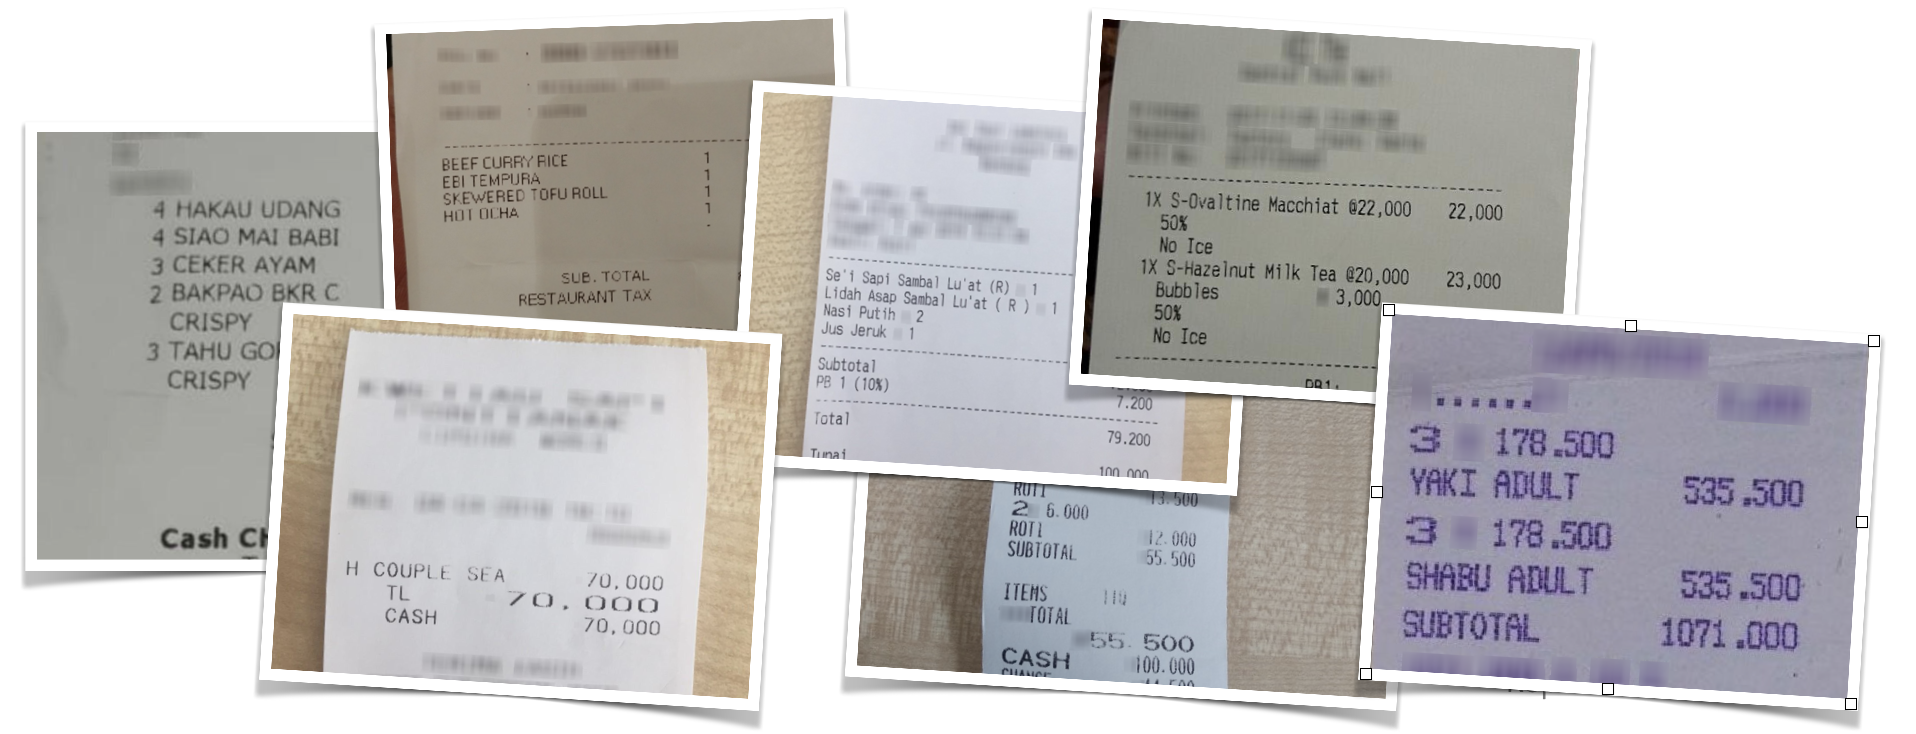

🔎 With this model, you can detect Receipts on both scanned and mobile images using Financial Image Transformers (ViT) in Spark NLP. You can use this model to retrieve all the images which are tickets and then process then using VisualNER, OCR, etc.

🔎 **`finvisualclf_tickets`** is a ViT (Visual Transformer) model, which can be used to carry out Binary Classification (true or false) on pictures / photos / images. 

🔎 Classes detected by the model:

* **ticket**
* **no_ticket** 

## Download Sample images

In [ ]:
!wget -q https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/finance-nlp/data/receipt_sample_images/image01.png
!wget -q https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/finance-nlp/data/receipt_sample_images/image02.png
!wget -q https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/finance-nlp/data/receipt_sample_images/image03.png
!wget -q https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/finance-nlp/data/receipt_sample_images/image04.png
!wget -q https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/finance-nlp/data/receipt_sample_images/image05.png
!wget -q https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/finance-nlp/data/receipt_sample_images/image06.png

## Load test images

In [ ]:
test_image = spark.read\
    .format("image")\
    .option("dropInvalid", value = True)\
    .load("*image0*.png").toDF("image")

In [ ]:
test_image.select("image.origin", "image.width", "image.height").show(truncate=False)

+---------------------------+-----+------+
|origin                     |width|height|
+---------------------------+-----+------+
|file:///content/image05.png|960  |1280  |
|file:///content/image01.png|1108 |1478  |
|file:///content/image02.png|1920 |2889  |
|file:///content/image06.png|1556 |1760  |
|file:///content/image04.png|1275 |1650  |
|file:///content/image03.png|1108 |1478  |
+---------------------------+-----+------+



In [ ]:
document_assembler =  nlp.ImageAssembler() \
    .setInputCol("image") \
    .setOutputCol("image_assembler")

imageClassifier_loaded = nlp.ViTForImageClassification.pretrained("finvisualclf_vit_tickets", "en", "finance/models")\
  .setInputCols(["image_assembler"])\
  .setOutputCol("classes")

pipeline = nlp.Pipeline().setStages([
    document_assembler,
    imageClassifier_loaded
])

finvisualclf_vit_tickets download started this may take some time.
Approximate size to download 306.9 MB
[OK!]


In [ ]:
result = pipeline.fit(test_image).transform(test_image).cache()

In [ ]:
result.show()

+--------------------+--------------------+--------------------+
|               image|     image_assembler|             classes|
+--------------------+--------------------+--------------------+
|{file:///content/...|[{image, file:///...|[{category, 0, 5,...|
|{file:///content/...|[{image, file:///...|[{category, 0, 5,...|
|{file:///content/...|[{image, file:///...|[{category, 0, 8,...|
|{file:///content/...|[{image, file:///...|[{category, 0, 8,...|
|{file:///content/...|[{image, file:///...|[{category, 0, 8,...|
|{file:///content/...|[{image, file:///...|[{category, 0, 5,...|
+--------------------+--------------------+--------------------+



In [ ]:
import pyspark.sql.functions as F

result_df = result.select(F.explode(F.arrays_zip(result.classes.result, 
                                                 result.classes.metadata)).alias("cols"))\
                  .select(F.expr("cols['1']['origin']").alias("images"),
                          F.expr("cols['0']").alias("class"),
                          F.expr("cols['1']['Some(ticket)']").alias("ticket_confidence"),
                          F.expr("cols['1']['Some(no_ticket)']").alias("no_ticket_confidence"))
                          

result_df.show(truncate=False)

+---------------------------+---------+-----------------+--------------------+
|images                     |class    |ticket_confidence|no_ticket_confidence|
+---------------------------+---------+-----------------+--------------------+
|file:///content/image05.png|ticket   |0.99478793       |0.0052120965        |
|file:///content/image01.png|ticket   |0.9956969        |0.004303068         |
|file:///content/image02.png|no_ticket|8.1447844E-4     |0.9991855           |
|file:///content/image06.png|no_ticket|8.130493E-4      |0.99918693          |
|file:///content/image04.png|no_ticket|8.138706E-4      |0.99918616          |
|file:///content/image03.png|ticket   |0.99545777       |0.0045422455        |
+---------------------------+---------+-----------------+--------------------+



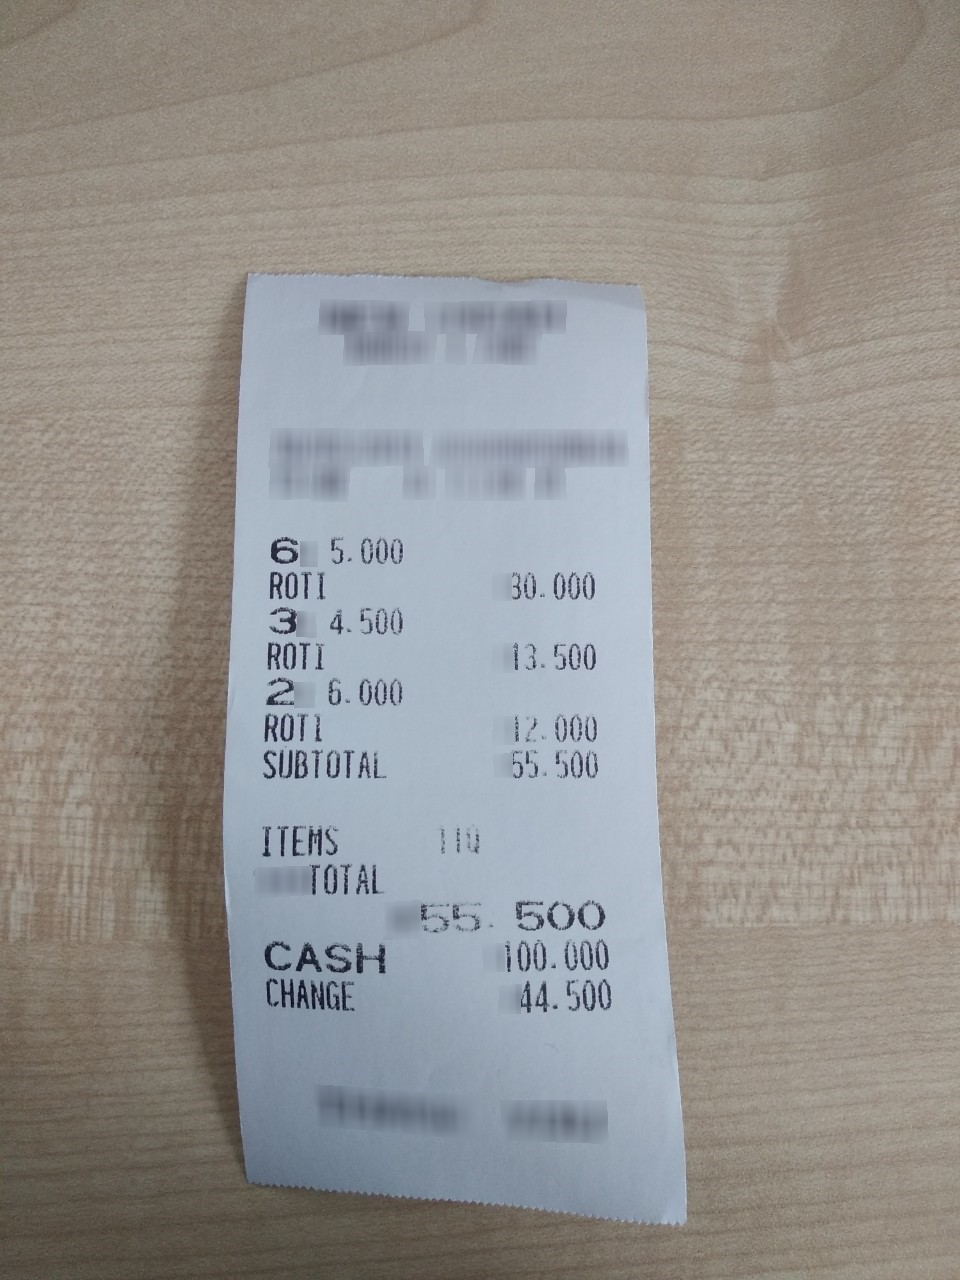

In [ ]:
from IPython.display import Image
Image(filename='image05.png') 

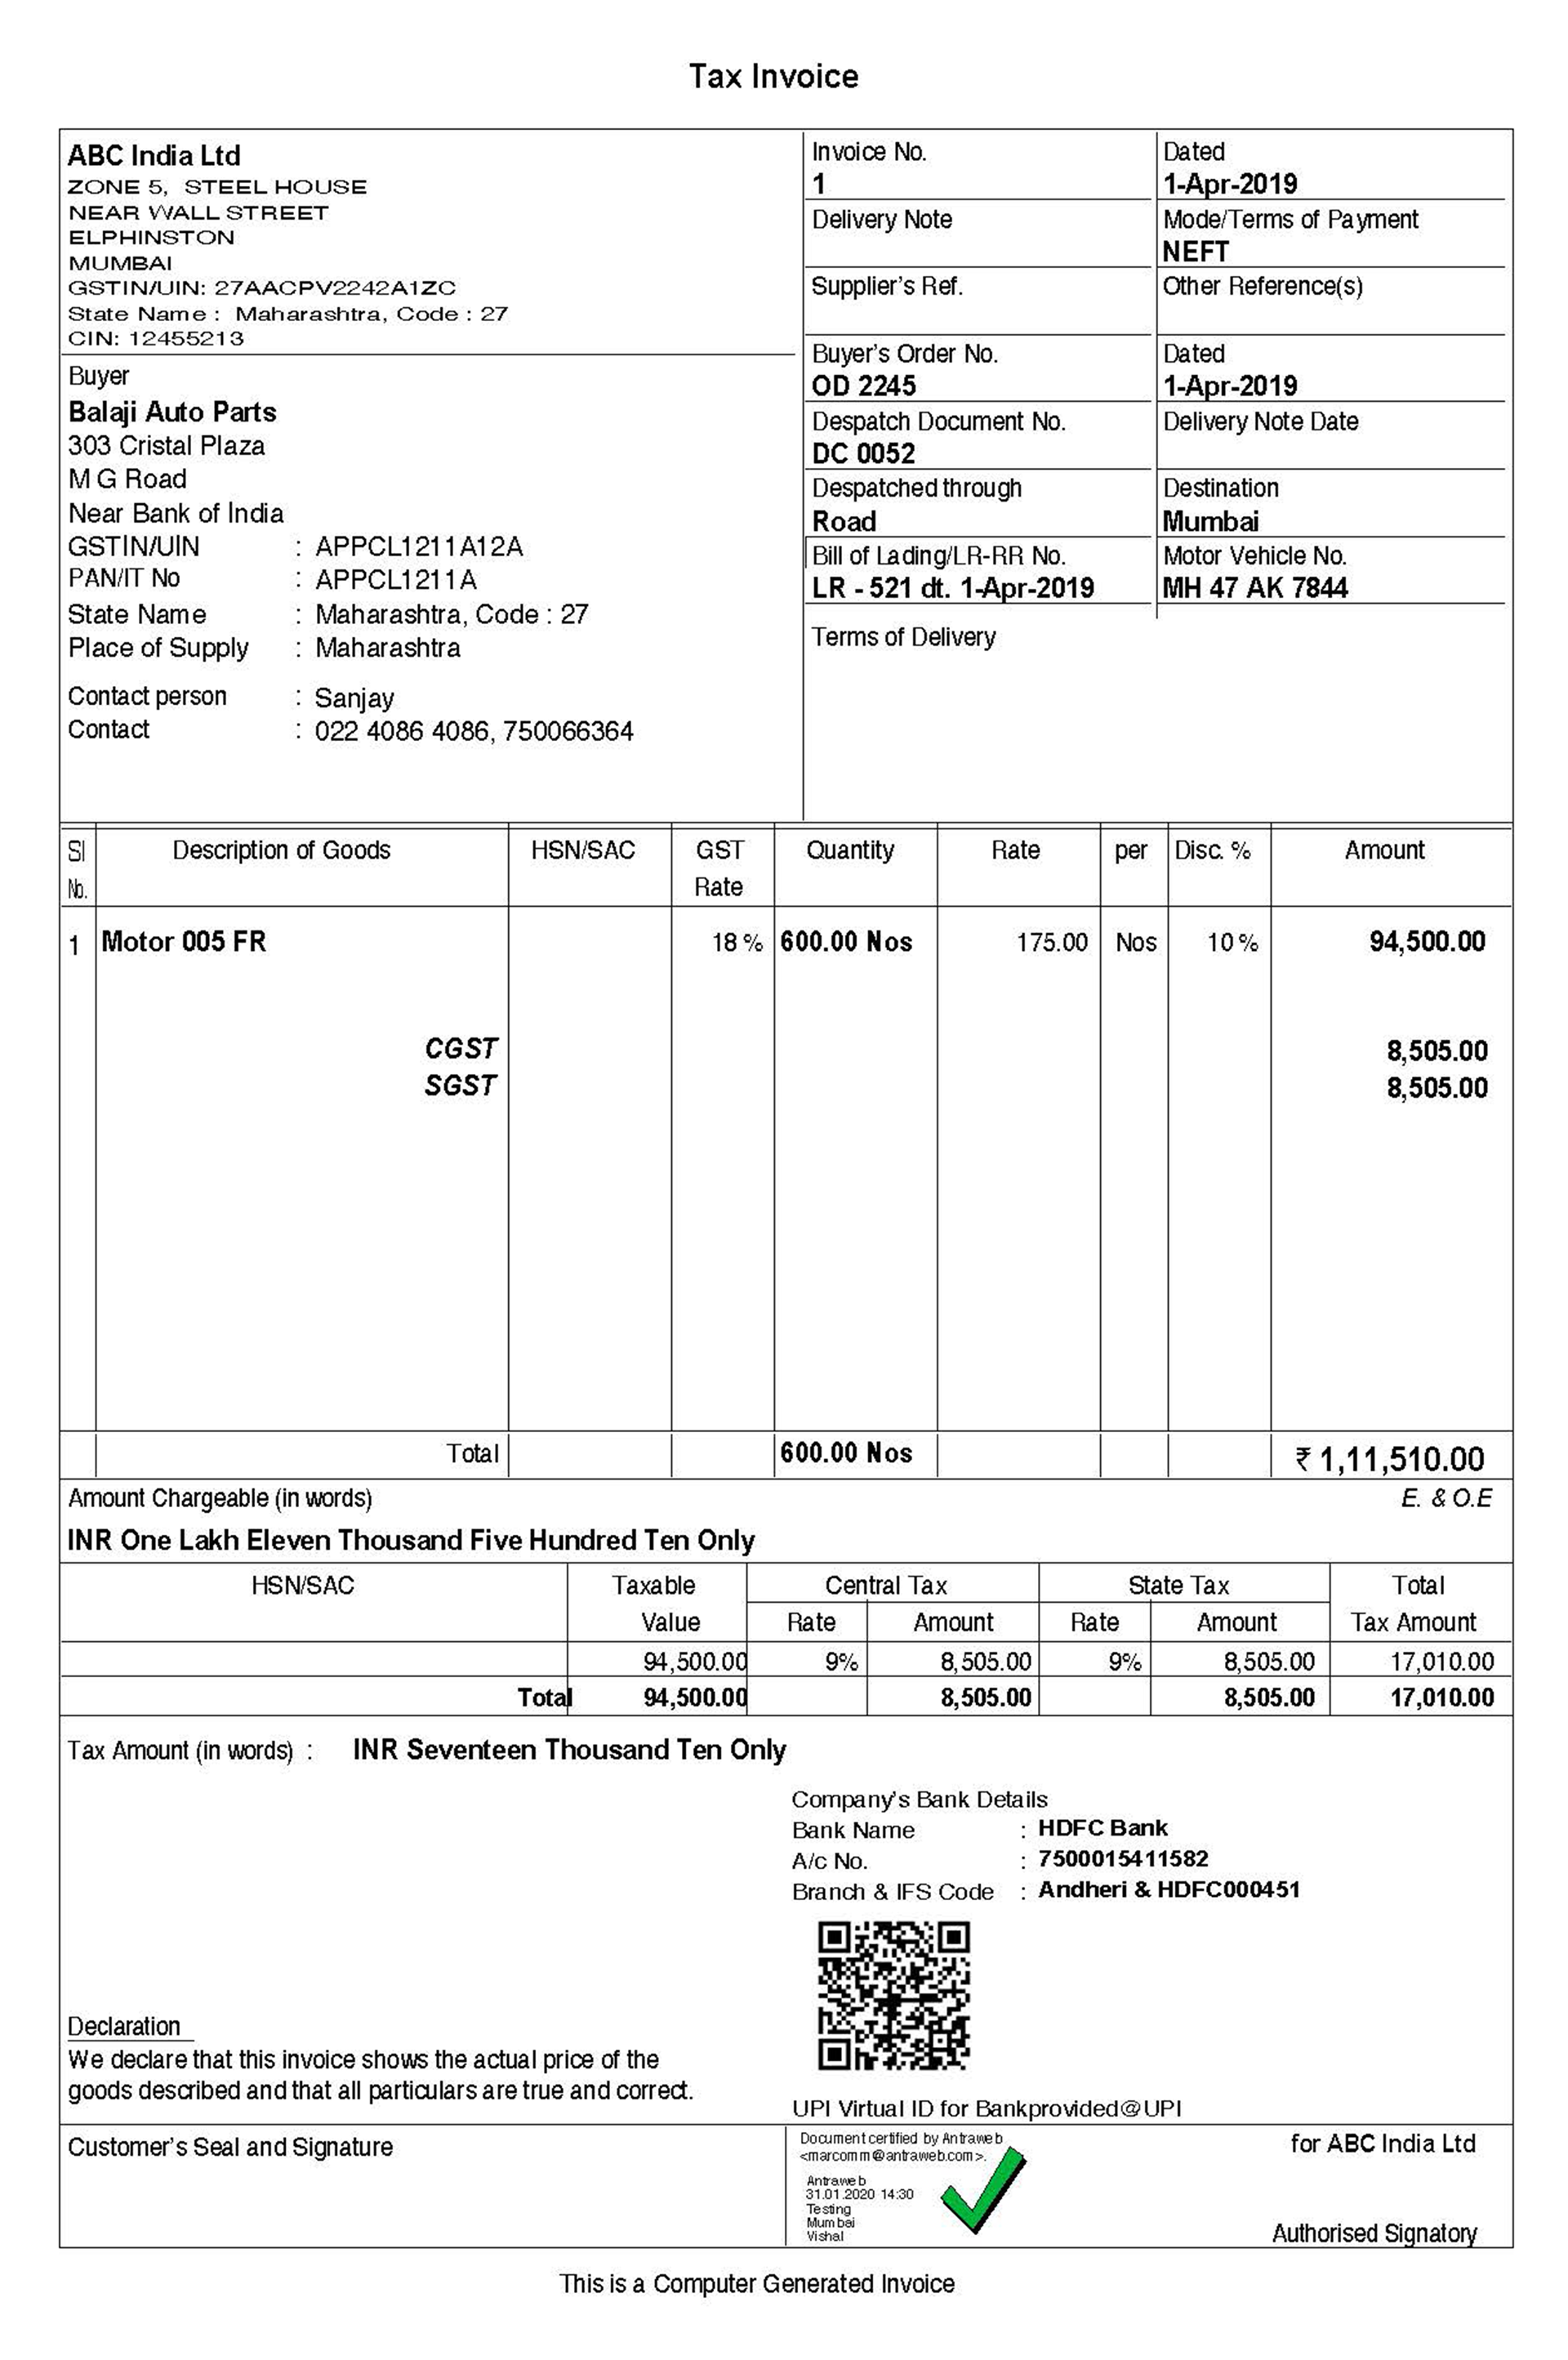

In [ ]:
from IPython.display import Image
Image(filename='image02.png') 